In [1]:
import numpy as np
from numpy import load
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from scipy import signal
import typing
import ffmpeg
import av

%matplotlib inline

In [2]:
data = load('data_ps1.npz')
data

NpzFile 'data_ps1.npz' with keys: environment, rod

# Task 1

## Subtask A

Visualize from the given data the workspace and the different rod configurations for each discretized
orientation. Comment on the given discretized values for orientation.

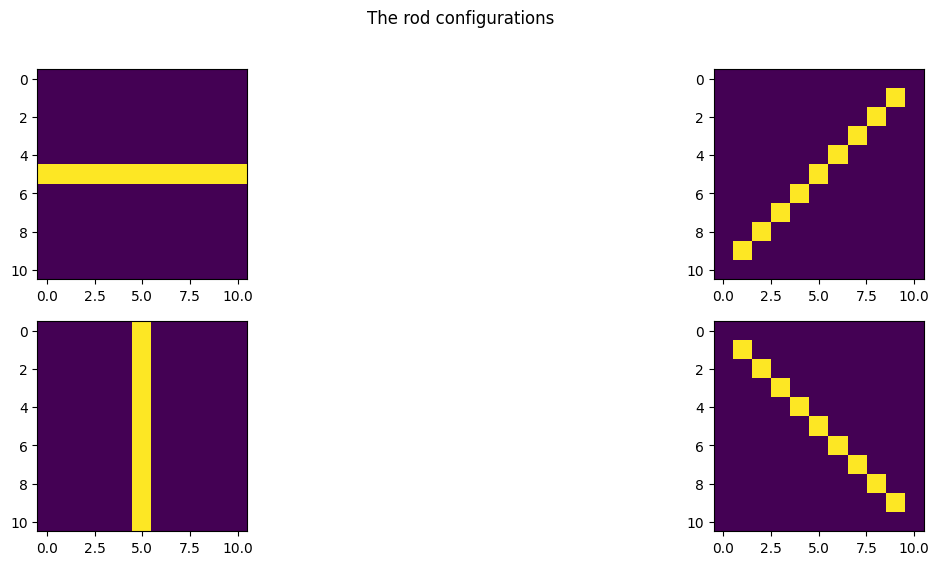

In [3]:
# Plotting the rod configurations:

fig, ax = plt.subplots(2, 2, figsize=(16, 6))
ax[0, 0].imshow(data["rod"][:, :, 0])
ax[0, 1].imshow(data["rod"][:, :, 1])
ax[1, 0].imshow(data["rod"][:, :, 2])
ax[1, 1].imshow(data["rod"][:, :, 3])
plt.suptitle("The rod configurations")
plt.show()

The visualization of the map:

Text(0.5, 1.0, 'The environment')

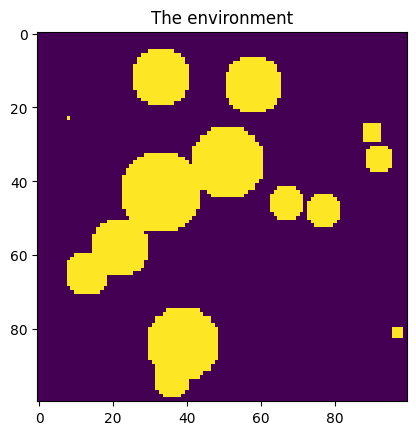

In [4]:
# Plotting the environment:

plt.imshow(data["environment"])
plt.title("The environment")

## Subtask B

Visualize the environment together with the object. For this, you may want to use the function
**plot_joint_environment** from **utils.py** and select any valid configuration value for the rod.

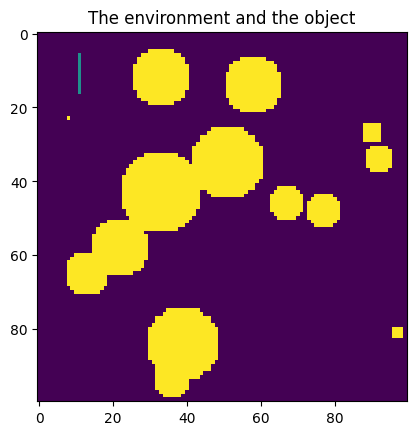

In [5]:
def plot_enviroment(img: np.ndarray, obj: np.ndarray, state: tuple):
    """
    @param img: original image in 2d
    @param obj: is the 3d array of different configurations
    @param state: is the current pose (x, y, orientation) of the object

    @return: the merged image
    """
    dims = obj.shape
    dim_x = int((dims[0] - 1) / 2)
    dim_y = int((dims[1] - 1) / 2)
    merged_img = np.copy(img)
    merged_img[state[0] - dim_x:state[0] + dim_x + 1, state[1] - dim_y:state[1] + dim_y + 1] += obj[:, :, state[2]] * 0.5
    return merged_img


b = plot_enviroment(data["environment"], data["rod"], (11, 11, 2))
plt.title("The environment and the object")
plt.imshow(b)

## Subtask C

Create the C-space for the 2D environment map. For this, plot all the images corresponding to each
of the orientations by using collision checking.

*hint*: you might want to look at the library **scipy.signal** and use function **signal.convolve2d(env_map,
kernel, boundary=’symm’, mode=’same’)** to check for collisions.

*hint*: you may want to use **normalize_image(img)** from **utils.py** to normalize created space to {0, 1},
since after convolutions, values are not exactly 0 and 1 (this will be useful for task 2).

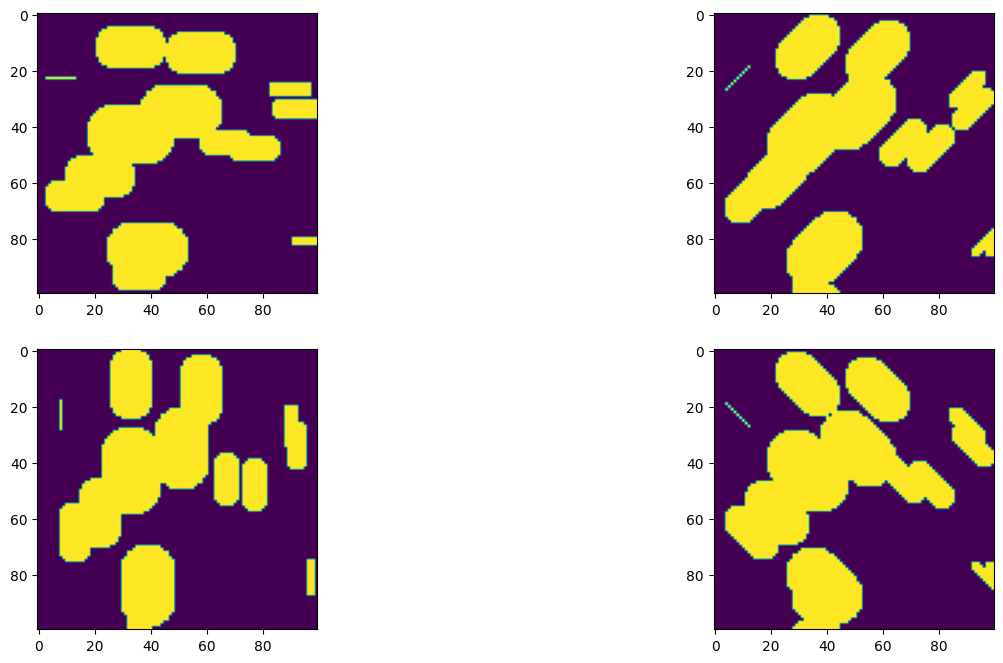

In [6]:
def normalize_image(img: np.ndarray, threshold: float = 0.1):
    """
    normalize the image to be between 0 and 1
    """
    dims = img.shape
    env = np.ones(dims)
    z = np.where(img < threshold)
    env[z] = 0.0
    return env

def c_space_plot(ax, env):
    ax.imshow(env)


c_list = []

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), layout=None)

for i in range(4):
    c_list.append(normalize_image(signal.convolve2d(data["environment"], data["rod"][:, :, i], boundary="symm", mode="same")))

k = 0
for ax in axs.flat:
    c_space_plot(ax, c_list[k])
    k += 1

## Subtask D

So due to the convolution we got 4 C-spaces for all 4 states of the rod. Now they will be used to check the collisions between the rod and obstacles. In the current task C-space has the dimentionality that is equal to 3, because the rod is able to move along the x and y axes and rotate. 

# Task 2

## Point A

You need to implement the A star algorithm and plan in the generated discrete C-space from the previous task. The starting configuration of the agent is (6,6,2) and the goal configuration is (55,55,0). On this first iteration, use an heuristic function h(q, qG) = 0, which is equivalent to the Dijkstra algorithm.

In [7]:
# The realisation of the priority queue:

def enqueue(p,
            config,
            cost,
           ):
    p.append((config, cost))
    return sorted(p, key=lambda tup: tup[1], reverse=True)

def dequeue(p
):
    if not p:
        return None
    return p.pop()[0]

In [8]:
# The realisation of the returning of the result

def returning(X_I,
              X_G, 
              dictionary,
             ):
    a = X_G
    b = 0
    s = [a]
    k = True
    while b != X_I:
        if k:
            b = a
            k = False
        b = dictionary[b][0]
        s.append(b)
    return s

In [9]:
# Cheking the neighbourhood conditions:

def set_neighbours(
    q
) -> typing.List[typing.List[int]]:
    cost = 0
    neighbours = []
    if q[0] > 6 and c_list[q[2]][q[0]-1, q[1]] != 1:
            neighbours.append([q[0]-1, q[1], q[2], cost+1])
    if q[0] < 94 and c_list[q[2]][q[0]+1, q[1]] != 1:
            neighbours.append([q[0]+1, q[1], q[2], cost+1])
    if q[1] > 6 and c_list[q[2]][q[0], q[1]-1] != 1:
            neighbours.append([q[0], q[1]-1, q[2], cost+1])
    if q[1] < 94 and c_list[q[2]][q[0], q[1]+1] != 1:
            neighbours.append([q[0], q[1]+1, q[2], cost+1])

    for j in [(q[2] - 1) % 4, (q[2] + 1) % 4]:
        if c_list[j][q[0], q[1]] == 0:
            neighbours.append([q[0], q[1], j, cost+1])

    return neighbours

In [10]:
# The realisatoin of the Dijkstra's algorithm with no heuristic:

def Dijkstra(X_I,
                     X_G,
                    ):

    Q = []
    Q = enqueue(Q, X_I, 0)
    visited = np.zeros((100, 100, 4))
    visited[X_I] = 1 
    queue = {X_I: (X_I, 0)} 
    states_visited = 0
    
    while Q:

        q = dequeue(Q)


        if q == X_G:
            return returning((6,6,2), (55,55,0), queue), visited.sum()

        for i in set_neighbours(q):
            c = (i[0], i[1], i[2])
            new_cost = queue[q][1] + i[3]           
            if visited[c] == 0:
                visited[c] = 1
                queue[c] = (q, new_cost)

                Q = enqueue(Q, c, new_cost)


            else:
                if queue[c][1] > new_cost:
                    queue[c] = (q, new_cost)

    return -1

X_I = (6, 6, 2)
X_G = (55, 55, 0)

result, visited_sum = Dijkstra(X_I, X_G)
result.reverse()
result = tuple(result)
print("The final score:", len(result))
print("The quantity of the visited cells:", visited_sum)

The final score: 117
The quantity of the visited cells: 11758.0


## Subtask B

Change the heuristic function now to be h(q, qG) = L1 norm of the x, y components. Comment on the changes, how many states have been visited compared to Dijkstra? What is the final cost? Comment on the results.

In [11]:
def A_star_algorithm_L1(X_I,
                     X_G,
                    ):

    Q = []
    Q = enqueue(Q, X_I, 0)
    visited = np.zeros((100, 100, 4))
    visited[X_I] = 1 
    queue = {X_I: (X_I, 0)} 
    states_visited = 0
    
    while Q:

        q = dequeue(Q)


        if q == X_G:
            return returning((6,6,2), (55,55,0), queue), visited.sum()

        for i in set_neighbours(q):
            c = (i[0], i[1], i[2])
            new_cost = queue[q][1] + i[3]           
            if visited[c] == 0:
                visited[c] = 1

                queue[c] = (q, new_cost)
                
                h = np.linalg.norm([X_G[0]-c[0], X_G[1]-c[1]], ord=1)
                Q = enqueue(Q, c, new_cost+h)



            else:
                if queue[c][1] > new_cost:
                    queue[c] = (q, new_cost)

    return -1

X_I = (6, 6, 2)
X_G = (55, 55, 0)

result, visited_sum = A_star_algorithm_L1(X_I, X_G)
result.reverse()
result = tuple(result)
print("The final score:", len(result))
print("The quantity of the visited cells:", visited_sum)

The final score: 117
The quantity of the visited cells: 4371.0


With the L1 norm we received a much better (4371 < 11578) result in terms of quantity of the cells, that we had to go through to come up with the right answer. The final cost remained the same.

## Subtask C

Propose an heuristic function h(q, qG) that includes orientation. Compare metrics with the previous results. Comment on the results.

In [12]:
def A_star_algorithm_new_H(X_I,
                     X_G,
                    ):

    Q = []
    Q = enqueue(Q, X_I, 0)
    visited = np.zeros((100, 100, 4))
    visited[X_I] = 1 
    queue = {X_I: (X_I, 0)}
    states_visited = 0
    
    while Q:

        q = dequeue(Q)


        if q == X_G:
            return returning((6,6,2), (55,55,0), queue), visited.sum()

        for i in set_neighbours(q):
            c = (i[0], i[1], i[2])
            new_cost = queue[q][1] + i[3]           
            if visited[c] == 0:
                visited[c] = 1

                queue[c] = (q, new_cost)
                
                h = np.linalg.norm([X_G[0]-c[0], X_G[1]-c[1]], ord=1) + abs(0-c[2])
                Q = enqueue(Q, c, new_cost+h)



            else:
                if queue[c][1] > new_cost:
                    queue[c] = (q, new_cost)

    return -1

X_I = (6, 6, 2)
X_G = (55, 55, 0)

result, visited_sum = A_star_algorithm_new_H(X_I, X_G)
result.reverse()
result = tuple(result)
print("The final score:", len(result))
print("The quantity of the visited cells:", visited_sum)

The final score: 117
The quantity of the visited cells: 4176.0


Here is the heuristic takes into account not only the coordinates, but the state (the angle of the rod rotation). Actually, for the station the formula |0 - current_state|, because the final state of the rod is supposed to be 0. It gives a slight improvement in the quantity of the visited cells (4176 < 4371).

Visualization:

MovieWriter ffmpeg unavailable; using Pillow instead.


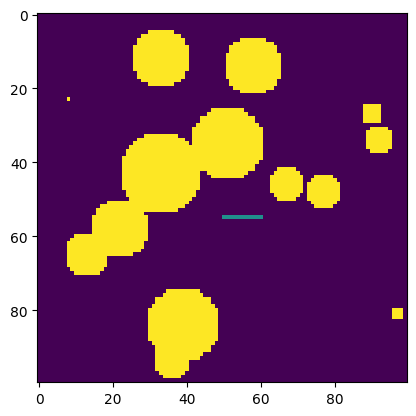

In [13]:
def plot_enviroment(img: np.ndarray, obj: np.ndarray, state: tuple):
    """
    @param img: original image in 2d
    @param obj: is the 3d array of different configurations
    @param state: is the current pose (x, y, orientation) of the object

    @return: the merged image
    """
    dims = obj.shape
    dim_x = int((dims[0] - 1) / 2)
    dim_y = int((dims[1] - 1) / 2)
    merged_img = np.copy(img)
    merged_img[state[0] - dim_x:state[0] + dim_x + 1, state[1] - dim_y:state[1] + dim_y + 1] += obj[:, :, state[2]] * 0.5
    return merged_img

def plotting_results(environment: np.ndarray, rod: np.ndarray, plan: list, save_path: str = 'rod_solve.gif'):
    """
    create an animation of the plan and save it to a file

    @param environment: the environment image in 2d
    @param rod: is the 3d array of different configuration
    @param plan: list of poses
    @param save_path: path to save the animation
    """

    fig = plt.figure()
    imgs = []

    for s in plan:
        im = plot_enviroment(environment, rod, s)
        plot = plt.imshow(im)
        imgs.append([plot])

    ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True)    

    ani.save(save_path)

    plt.show()
    
plotting_results(data["environment"], data["rod"], result)